# Experiment: What is the best split criteria?

Vivek Gopalakrishnan | October 16, 2019

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

from rf import RF, RFDecisionNode

## Generate synthetic data

$$
X_i \sim \text{MVN}(\vec{0}, I_2) \\
Y_i = A_{\theta}X_i
$$
where $A_{\theta}$ is a rotation matrix parameterized by $\theta$.

$D_n = \{(X_i, y_i)\}$ for $i=1,\dots,n$.

In [2]:
def generate_data(
    n=25, 
    mean=[0, 0], 
    cov=[[1, 0], [0, 1]],
    theta=np.pi/4
):
    """
    Generate synthetic data. 
    X ~iid MVN(u=0, cov=I).
    y = AX where A is a rotation matrix.
    """
    
    # Rotation matrix
    A = [
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ]
    
    # Sample random variables
    X = np.random.multivariate_normal(mean, cov, size=n)
    y = np.dot(A, X.T)
    
    return X, y.T

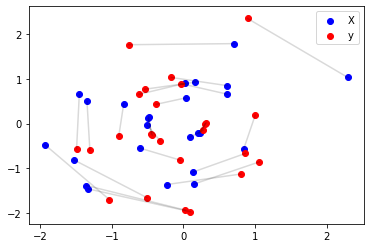

In [3]:
# Test default parameters

X, y = generate_data()

plt.scatter(X[:, 0], X[:, 1], c="blue", label="X")
plt.scatter(y[:, 0], y[:, 1], c="red", label="y")

# Plot lines between matched pairs of points
for xi, yi in zip(X, y):
    plt.plot(
        [xi[0], yi[0]], 
        [xi[1], yi[1]], 
        c="black", 
        alpha = 0.15
    )

plt.legend()
plt.show()

## Random Forest

Split criteria being tested:

1. MAE
2. MSE
3. Axis projections
4. Random projections

In [4]:
def predict(rf, X):
    """
    Return predictions for every element in X.
    """
    
    yhat = []
    for xi in X:
        yi = np.mean(rf.predict(xi), axis=0)
        yhat.append(yi)
        
    return np.array(yhat)

In [5]:
def measure_mse(X, y, max_depth=10, n_features=1, min_leaf_size=5, n_trees=1000, n_bagging=10):
    """
    Return MSE for each split criteria.
    """
    
    # Make a set of default parameters
    default = {
        "max_depth": max_depth, 
        "n_features": n_features, 
        "min_leaf_size": min_leaf_size, 
        "n_trees": n_trees, 
        "n_bagging": n_bagging,
    }
    
    # Iterate over different split criteria
    errors = []
    for split in ["mae", "mse", "projection_axis", "projection_random"]:

        # Fit model
        rf = RF(X, y, criteria=split, **default)
        rf.create_model()

        # Make predictions and score
        yhat = rf.predict(X)
        mse = np.linalg.norm(y-yhat)
        errors.append(mse)
        
    return errors

In [6]:
# Test functions on sample data
measure_mse(X, y)

[4.337423398785024, 4.339409677106577, 5.42763581469879, 6.010109624065488]

## Simulation

Measure the effect of sample size on MSE. Choose $n=10, 20, \dots, 200$.

In [7]:
# Run simulation
results = []
max_n = 201
n_iter = 10

for n in tqdm(range(10, max_n, 10)):
    for i in range(n_iter):
        
        # Generate sample data
        X, y = generate_data(n=n)
        
        # Measure MSE
        mse = measure_mse(X, y)
        
        # Add to dataframe
        mse.insert(0, n)
        results.append(mse)

100%|██████████| 20/20 [14:57<00:00, 44.90s/it]


In [8]:
# Convert to dataframe
columns = ["mae", "mse", "projection_axis", "projection_random"]
columns.insert(0, "n")
df = pd.DataFrame(results, columns=columns)
df = pd.melt(df, id_vars=['n'], value_vars=columns[1:], var_name='split', value_name='mse')
df["mse"] /= df["n"]
df.head()

,n,split,mse
0,10,mae,0.249055
1,10,mae,0.333163
2,10,mae,0.275013
3,10,mae,0.347680
4,10,mae,0.255068


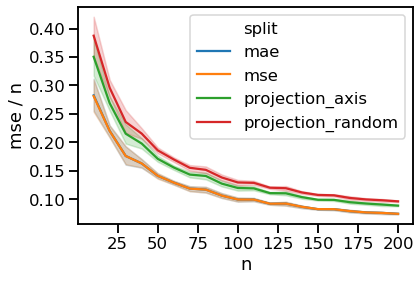

In [9]:
with sns.plotting_context("talk", font_scale=1):
    
    f = sns.lineplot(x="n", y="mse", hue="split", data=df)
    f.set(xlabel="n", ylabel="mse / n")